7장 순환 신경망

In [ ]:
# 예제 7.5 LSTM 주가 예측(삼성전자)

# finance-datareader 설치
!pip install finance-datareader

In [ ]:
# 셋업
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import timeseries_dataset_from_array
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터셋 준비
df = fdr.DataReader('005930', '2010-01-01', '2023-12-31')   # 삼성전자

In [ ]:
# 상위 데이터 출력
df.head(3)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516
2010-01-05,16520,16580,16300,16440,559219,0.016069
2010-01-06,16580,16820,16520,16820,459755,0.023114


In [ ]:
# mplfinance 설치
!pip install mplfinance

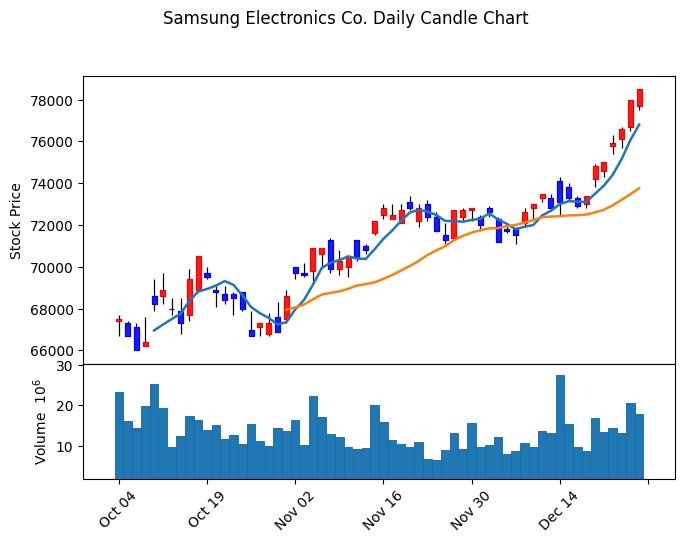

In [ ]:
# 일봉 차트
import mplfinance as mpf

candle_df = df['2023-10-01':'2023-12-31']

mc = mpf.make_marketcolors(up='red', down='blue', edge='inherit')
style = mpf.make_mpf_style(marketcolors=mc)

mpf.plot(candle_df,
         type='candle',   # 캔들 차트
         mav=(5, 20),   # 이동 평균선 5/20일
         volume=True,   # 거래량 표시
         style=style,   # 색상 지정
         figratio=(10, 7),   # 가로/세로 크기 지정
         title='Samsung Electronics Co. Daily Candle Chart',
         ylabel='Stock Price')

In [ ]:
# 불필요한 컬럼 제거
df = df.drop('Change', axis=1)

In [ ]:
# 정규화
min = df.min()
max = df.max()

stock_df = (df - min) / (max - min)

In [ ]:
# 시퀀스 데이터셋 준비
sequence_length = 3   # 3일간의 데이터 입력
offset = 1   # 다음 날 주가 예측
shift = sequence_length + offset - 1   # 레이블 위치

train_ds = timeseries_dataset_from_array(   # 학습 데이터셋
    data=stock_df['2010-01':'2021-12'].to_numpy()[:-shift],
    targets=stock_df['Close']['2010-01':'2021-12'].to_numpy()[shift:],
    sequence_length=sequence_length,
    batch_size=32,
    shuffle=False)

valid_ds = timeseries_dataset_from_array(   # 검증 데이터셋
    data=stock_df['2022-01':'2022-12'].to_numpy()[:-shift],
    targets=stock_df['Close']['2022-01':'2022-12'].to_numpy()[shift:],
    sequence_length=sequence_length,
    batch_size=32,
    shuffle=False)

test_ds = timeseries_dataset_from_array(   # 테스트 데이터셋
    data=stock_df['2023-01':'2023-12'].to_numpy()[:-shift],
    targets=stock_df['Close']['2023-01':'2023-12'].to_numpy()[shift:],
    sequence_length=sequence_length,
    batch_size=32,
    shuffle=False)

for inputs, targets in train_ds.take(1):
  print(inputs.shape)   # 입력 shape 확인
  print(targets.shape)   # 레이블 shape 확인

(32, 3, 5)
(32,)


In [ ]:
# 모델 생성
model = Sequential([
    LSTM(8, return_sequences=True,
         input_shape=(sequence_length, 5)),   # 입력 특징 5개
    LSTM(8),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 8)              448       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 1001 (3.91 KB)
Trainable params: 1001 (3.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # 모니터링 지표 지정
    patience=3)   # 허용 범위 지정

history = model.fit(train_ds, epochs=50, verbose=0,
                    validation_data=valid_ds,
                    callbacks=early_stopping)

8/8 [==============================] - 0s 12ms/step


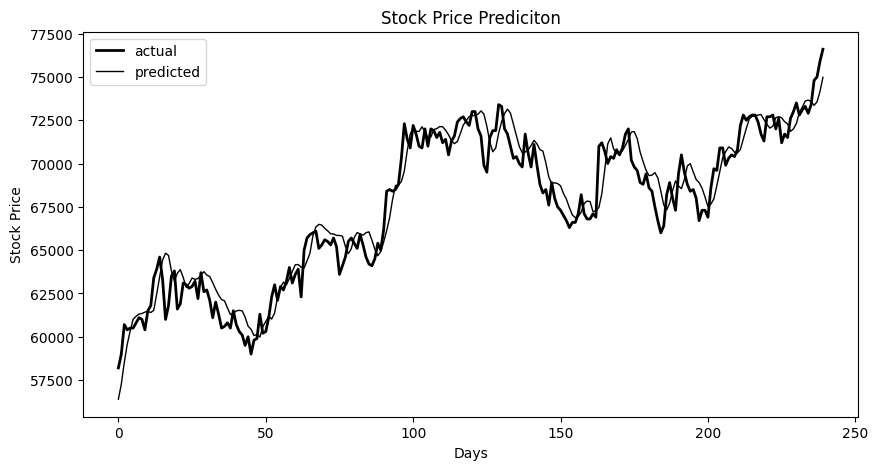

In [ ]:
# 예측 결과 시각화
max_C = df['Close'].max()   # 종가의 최대값
min_C = df['Close'].min()   # 종가의 최소값

y_pred = model.predict(test_ds)
y_pred = y_pred * (max_C - min_C) + min_C

y_test = []
for _, targets in test_ds:
    y_test.extend(targets)
y_test = np.array(y_test) * (max_C - min_C) + min_C

plt.figure(figsize=(10, 5))

plt.plot(y_test, label='actual', color='black', linewidth=2)
plt.plot(y_pred, label='predicted', color='black', linewidth=1)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediciton')
plt.legend()

plt.show()

In [ ]:
# 예제 7.8 양방향 LSTM 감성 분석(한글 NSMC 데이터셋)

# KoNLPy 설치
!pip install konlpy

In [ ]:
# 셋업
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.layers import TextVectorization
from konlpy.tag import Okt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 데이터셋 다운로드
url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
train_df = pd.read_csv(url, sep='\t')   # 학습 데이터

url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
test_df = pd.read_csv(url, sep='\t')    # 테스트 데이터

# 소규모 데이터셋 준비
train_df = train_df.iloc[::10].reset_index(drop=True)   # 1/10 축소
test_df = test_df.iloc[::20].reset_index(drop=True)   # 1/20 축소

print(train_df.shape)   # 학습 데이터 shape 확인
print(test_df.shape)   # 테스트 데이터 shape 확인

(15000, 3)
(2500, 3)


In [ ]:
# 상위 데이터 확인
train_df.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,9008700,걍인피니트가짱이다.진짜짱이다♥,1
2,4581211,나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님,1
3,6331922,엄포스의 위력을 다시 한번 깨닫게 해준 적.남 꽃검사님도 연기 정말 좋았어요! 완전...,1
4,9336496,단순하면서 은은한 매력의 영화,1
5,9063648,영화가 사람의 영혼을 어루만져 줄 수도 있군요 거친 세상사를 잠시 잊고 동화같은 영...,1
6,1031725,보는내내 그대로 들어맞는 예측 카리스마 없는 악역,0
7,2192046,아 일본영화 다이런건가?? 유치하다,0
8,2009382,뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..,0
9,7852366,성룡영화중 최악인듯 ㅋㅋ,0


In [ ]:
# 레이블별(긍정/부정) 수 확인
print(f"train dataset: \n{train_df['label'].value_counts()} \n")
print(f"test dataset: \n{test_df['label'].value_counts()}")

train dataset: 
0    7500
1    7500
Name: label, dtype: int64 

test dataset: 
1    1283
0    1217
Name: label, dtype: int64


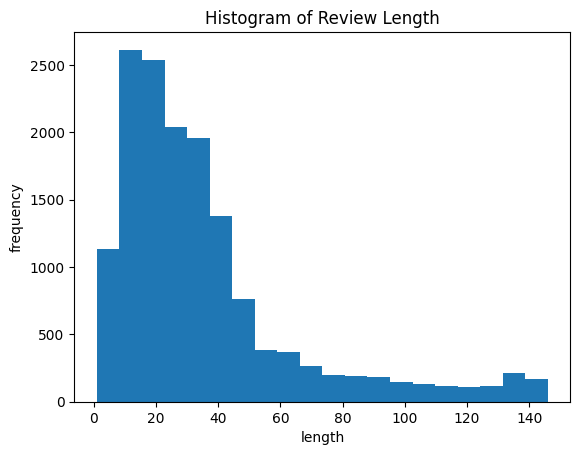

In [ ]:
# 학습 데이터 시각화(리뷰 길이 히스토그램)
length = train_df['document'].str.len()

plt.hist(length, bins=20)
plt.xlabel('length')
plt.ylabel('frequency')
plt.title('Histogram of Review Length')

plt.show()

In [ ]:
# 텍스트 정제
train_df['document'] = train_df['document'].str.replace(
    "[^A-Za-z가-힣]", " ", regex=True)

# 한글 형태소 분석
okt = Okt()   # 한글 형태소 분석기

stop_words = ['가', '을', '은', '과', '의', '도',  # 불용어 지정
              '이', '를', '는', '와', '에', '들']

def tokenize(text):   # 토큰화 함수 정의
    tokens = okt.morphs(text)
    return [token for token in tokens if token not in stop_words]

train_df['document'] = train_df['document'].apply(lambda x: ' '.join(tokenize(x)))

# 토큰화 결과 확인
train_df.head(10)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,9008700,걍 인피니트 짱 이다 진짜 짱 이다,1
2,4581211,나름 심오한 뜻 있는 듯 그냥 학생 선생 놀아나는 영화 절대 아님,1
3,6331922,엄포스 위력 다시 한번 깨닫게 해준 적 남 꽃 검사 님 연기 정말 좋았어요 완전 명...,1
4,9336496,단순하면서 은은한 매력 영화,1
5,9063648,영화 사람 영혼 어루만져 줄 수도 있군요 거친 세 상사 잠시 잊고 동화 같은 영화 ...,1
6,1031725,보는내내 그대로 들어맞는 예측 카리스마 없는 악역,0
7,2192046,아 일본 영화 다 이런 건가 유치하다,0
8,2009382,뭐 냐 시작 하고 분만 나왔다 리플릿 사진 보며 불안하더니만,0
9,7852366,성룡 영화 중 최악 인 듯,0


In [ ]:
# 워드 클라우드 라이브러리 설치
!pip install wordcloud

In [ ]:
# 한글 폰트를 사용하기 위해 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


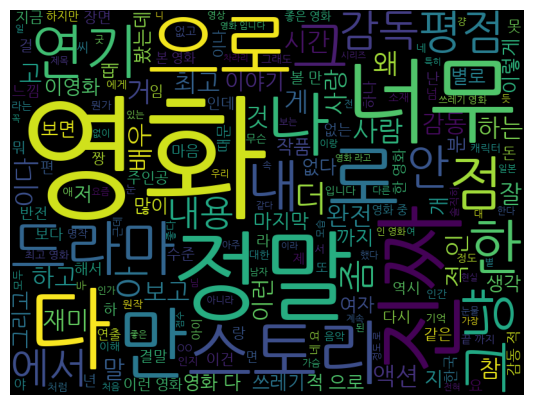

In [ ]:
# 워드 클라우드 시각화
from wordcloud import WordCloud

font_path = '/content/drive/MyDrive/Colab Notebooks/NanumFont/NanumGothic.ttf'
cloud = WordCloud(font_path=font_path, width=800, height=600)\
    .generate(" ".join(train_df['document']))

plt.figure(figsize=(10, 5))
plt.imshow(cloud)
plt.axis('off')

plt.show()

In [ ]:
# 텍스트 벡터화
vocab_size = 20000   # 어휘 사전 크기
sequence_length = 50   # 시퀀스 길이

vectorizer = TextVectorization(max_tokens=vocab_size,
                               standardize='lower_and_strip_punctuation',
                               split='whitespace',
                               output_mode='int',   # 정수 출력
                               output_sequence_length=sequence_length)

vectorizer.adapt(train_df['document'])   # 어휘 사전 생성

word_indexing = dict(zip(vectorizer.get_vocabulary(),
                         range(len(vectorizer.get_vocabulary()))))
print(f"word_indexing: {word_indexing}")   # 단어 인덱싱 확인

train_ds = vectorizer(train_df['document'])
print(train_ds[5])   # 텍스트 벡터화 확인

original_text = ' '.join(
    vectorizer.get_vocabulary()[i] for i in train_ds[5].numpy())
print(original_text)   # 원래의 텍스트 확인

word_indexing: {'': 0, '[UNK]': 1, '영화': 2, '너무': 3, '한': 4, '다': 5, '정말': 6, '만': 7, '적': 8, '으로': 9, '진짜': 10, '로': 11, '점': 12, '에서': 13, '것': 14, '연기': 15, '내': 16, '평점': 17, '나': 18, '최고': 19, '잘': 20, '인': 21, '이런': 22, '그': 23, '안': 24, '스토리': 25, '생각': 26, '이다': 27, '드라마': 28, '사람': 29, '못': 30, '왜': 31, '게': 32, '감동': 33, '고': 34, '아': 35, '보고': 36, '하는': 37, '더': 38, '배우': 39, '거': 40, '감독': 41, '시간': 42, '말': 43, '하고': 44, '본': 45, '요': 46, '때': 47, '그냥': 48, '재미': 49, '내용': 50, '뭐': 51, '좀': 52, '까지': 53, '쓰레기': 54, '중': 55, '지': 56, '없는': 57, '네': 58, '보다': 59, '수': 60, '볼': 61, '봤는데': 62, '할': 63, '정도': 64, '사랑': 65, '다시': 66, '좋은': 67, '마지막': 68, '작품': 69, '없다': 70, '저': 71, '같은': 72, '액션': 73, '처음': 74, '있는': 75, '완전': 76, '입니다': 77, '돈': 78, '하나': 79, '이건': 80, '주인공': 81, '라': 82, '참': 83, '장면': 84, '없고': 85, '걸': 86, '개': 87, '보는': 88, '별로': 89, '이렇게': 90, '이야기': 91, '하': 92, '연출': 93, '봐도': 94, '임': 95, '부터': 96, '지금': 97, '느낌': 98, '최악': 99, '면': 100, '그리고': 101, '듯

In [ ]:
# 학습/검증 데이터 분할
train_size = int(0.8 * len(train_ds))

x_train = train_ds[:train_size]
x_valid = train_ds[train_size:]
y_train = train_df['label'][:train_size]
y_valid = train_df['label'][train_size:]

print(x_train.shape, y_train.shape)   # 학습 데이터 shape 확인
print(x_valid.shape, y_valid.shape)   # 검증 데이터 shape 확인

(12000, 50) (12000,)
(3000, 50) (3000,)


In [ ]:
# 모델 생성
model = Sequential([
    Embedding(vocab_size, 128),   # 임베딩 벡터 128차원
    Bidirectional(LSTM(16, return_sequences=True)),   # 뉴런 16개
    Bidirectional(LSTM(16)),   # 뉴런 16개
    Dense(1, activation='sigmoid')   # 출력층 뉴런 1개
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(x_train, y_train, batch_size=32, epochs=5,
                    verbose=0,
                    validation_data=(x_valid, y_valid))

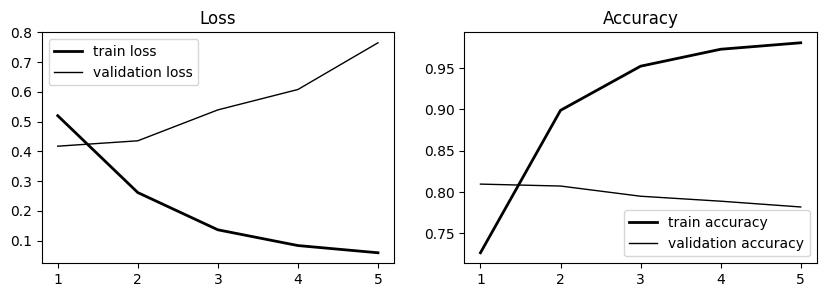

In [ ]:
# 학습 결과 시각화
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axs[0].plot(range(1, len(history.history['loss']) + 1),
            history.history['loss'], label='train loss',
            color='black', linewidth=2)
axs[0].plot(range(1, len(history.history['val_loss']) + 1),
            history.history['val_loss'], label='validation loss',
            color='black', linewidth=1)
axs[0].set_title('Loss')
axs[0].legend(loc='best')

axs[1].plot(range(1, len(history.history['accuracy']) + 1),
            history.history['accuracy'], label='train accuracy',
            color='black', linewidth=2)
axs[1].plot(range(1, len(history.history['val_accuracy']) + 1),
            history.history['val_accuracy'], label='validation accuracy',
            color='black', linewidth=1)
axs[1].set_title('Accuracy')
axs[1].legend(loc='best')

plt.show()

In [ ]:
# 모델 평가
test_ds = test_df['document'].str.replace(
    "[^A-Za-z가-힣]", " ", regex=True)   # 텍스트 정제
test_ds = test_ds.apply(lambda x: ' '.join(tokenize(x)))   # 토큰화
test_ds = vectorizer(test_ds)   # 텍스트 벡터화

model.evaluate(test_ds, test_df['label'])

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7685 - loss: 0.7844


[0.7871538996696472, 0.770799994468689]

In [ ]:
# 모델 예측
prediction = model.predict(test_ds)
predict = (prediction >= 0.5).astype(int)   # 임계치 0.5

for i in range(5):
    print(f"document: {test_df['document'][i]}")
    print(f"label: {test_df['label'][i]}")
    print(f"predict: {predict[i].item()} \n")

79/79 [==============================] - 0s 5ms/step
document: 굳 ㅋ
label: 1
predict: 1 

document: '13일의 금요일', '나이트메어'시리즈와 함께 가장 많은 시리즈를 양산해냈던 헬레이저 시리즈의 첫편. 작가의 상상력이 돋보이는 작품이며, 갈고리로 사지찢는 고어씬은 지금보더라도 상당히 잔인하고 충격적이다.
label: 1
predict: 0 

document: EBS 한국영화특선 해서 봤다.Biff 개막작 선정되서 왤까 궁금 했었는데 봐도 이율 모르겠다...
label: 0
predict: 0 

document: 콩콩~~~~ㅋㄲㅈㅁ
label: 0
predict: 0 

document: 솔직히 이건 C급 그 이하의 영화이긴 함 ㅎㅎ;
label: 0
predict: 0 



In [ ]:
# 모델 예측(실제 텍스트 입력)
import re

sentence = "미션 임파서블 7은 역시 기대에 어긋나지 않는다."

text = re.sub("[^A-Za-z가-힣]", " ", sentence)   # 텍스트 정제
text = ' '.join(tokenize(text))   # 토큰화
text = vectorizer(text)   # 텍스트 벡터화

text = np.expand_dims(text, axis=0)   # 배치 차원 추가

prediction = model.predict(text)
predict = (prediction >= 0.5).astype(int)   # 임계치 0.5

print(f"sentence: {sentence}")
print(f"predict: {int(predict)}")

1/1 [==============================] - 0s 20ms/step
sentence: 미션 임파서블 7은 역시 기대에 어긋나지 않는다.
predict: 1


In [ ]:
# 예제 7.12(a) 트랜스포머를 이용한 감성 분석

# 허깅페이스 트랜스포머 설치
!pip install transformers

In [ ]:
# 감성 분석 파이프라인
from transformers import pipeline

classifier = pipeline('sentiment-analysis')

In [ ]:
# 모델 구조 확인
classifier.model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# 감성 분석(IMDB 오펜하이머 리뷰)
text1 = "This movie is very interesting and very thrilling. \
    Since this movie had no action and was mostly just a documentary \
    and was 3 hours long, I thought that it was going to be boring. \
    But, the 3 hours went by very fast and had me \
    at the edge of my seat the whole time."

text2 = "Christopher Nolan's Oppenheimer is a bloated, overwrought, \
    and ultimately unsatisfying film. The film is three hours long, \
    but it feels even longer, thanks to Nolan's penchant \
    for unnecessary scenes and characters. The supporting characters are \
    all flat and one-dimensional, and they don't have enough time to develop."

print(classifier(text1))
print(classifier(text2))

[{'label': 'POSITIVE', 'score': 0.9978258013725281}]
[{'label': 'NEGATIVE', 'score': 0.9996480941772461}]


In [ ]:
# 예제 7.12(b) 트랜스포머를 이용한 문장 생성

# 문장 생성 파이프라인
from transformers import pipeline

generator = pipeline('text-generation',
                     model='skt/kogpt2-base-v2',
                     tokenizer='skt/kogpt2-base-v2')

# 모델 구조 확인
generator.model

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
# 문장 생성
prompt = "오늘 날씨가 정말"   # 시작 문장

generated_text = generator(prompt,
                           max_length=30,   # 생성할 단어 수
                           num_return_sequences=2,   # 생성할 문장의 수
                           temperature=0.7,   # 소프트맥스 온도
                           truncation=True)   # 텍스트 길이 자르기
print(generated_text)

[{'generated_text': '오늘 날씨가 정말 좋아서 나들이 가기 정말 좋은 날씨였습니다.\n오늘 낮기온 서울 26도 등 어제보다 3도에서 6도 가량 높은 기온을'}, {'generated_text': '오늘 날씨가 정말 변덕스럽습니다.\n주말에도 이맘때쯤에는 비가 내리다가 오후부터 다시 시작되겠는데요.\n이번 비가 그치고'}]
